In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

2. LOAD DATA

In [3]:
df = pd.read_csv("bitcoin_data.csv")

3. Basic checks

In [4]:
print(df.shape)
print(df.columns)
df.head()

(2713, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
try:
    from xgboost import XGBRegressor
    has_xgb = True
except:
    has_xgb = False

In [6]:
# !pip install tensorflow

In [7]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    has_tf = True
    print("TensorFlow Loaded.")
except:
    has_tf = False
    print("TensorFlow Not Available.")

import warnings
warnings.filterwarnings("ignore")

TensorFlow Loaded.


3. DATA PREPROCESSING

In [8]:
# Auto-detect date column
date_col = None
for col in df.columns:
    if "date" in col.lower():
        date_col = col

df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(by=date_col)
df = df.set_index(date_col)


In [9]:
rename_map = {
    "close": "Close",
    "open": "Open",
    "high": "High",
    "low": "Low",
    "volume": "Volume"
}

for col in df.columns:
    for key in rename_map:
        if key in col.lower():
            df = df.rename(columns={col: rename_map[key]})


In [10]:
df = df.fillna(method="ffill").fillna(method="bfill")


In [11]:
# Remove duplicated column names
df = df.loc[:, ~df.columns.duplicated()]

# If Close is still a DataFrame, convert to Series
if isinstance(df["Close"], pd.DataFrame):
    df["Close"] = df["Close"].iloc[:, 0]


In [12]:
df["SMA_7"] = df["Close"].rolling(7).mean()
df["SMA_21"] = df["Close"].rolling(21).mean()

df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()


4. FEATURE ENGINEERING — Indicators

In [13]:
# SMA
df["SMA_7"] = df["Close"].rolling(7).mean()
df["SMA_21"] = df["Close"].rolling(21).mean()

# EMA
df["EMA_12"] = df["Close"].ewm(span=12).mean()
df["EMA_26"] = df["Close"].ewm(span=26).mean()

# Bollinger Bands
df["BB_Mid"] = df["Close"].rolling(20).mean()
df["BB_Std"] = df["Close"].rolling(20).std()
df["BB_Upper"] = df["BB_Mid"] + 2 * df["BB_Std"]
df["BB_Lower"] = df["BB_Mid"] - 2 * df["BB_Std"]

# RSI
delta = df["Close"].diff()
gain = delta.clip(lower=0).ewm(com=14, adjust=False).mean()
loss = (-delta.clip(upper=0)).ewm(com=14, adjust=False).mean()
RS = gain / loss
df["RSI"] = 100 - (100 / (1 + RS))

df = df.dropna()
df.head()


,Open,High,Low,Close,Volume,SMA_7,SMA_21,EMA_12,EMA_26,BB_Mid,BB_Std,BB_Upper,BB_Lower,RSI
Date,,,,,,,,,,,,,,
2014-10-07,330.584015,339.247009,320.481995,336.187012,49199900,347.691572,387.352142,358.057212,372.627522,383.853049,33.740796,451.334641,316.371457,15.177699
2014-10-08,336.115997,354.364014,327.187988,352.940002,54736300,343.309431,382.380999,357.249478,370.840477,380.278049,32.993690,446.265429,314.290668,20.527125
2014-10-09,352.747986,382.726013,347.687012,365.026001,83641104,341.874289,379.551761,358.472085,370.321362,378.789549,32.975773,444.741094,312.838004,24.221141
2014-10-10,364.687012,375.066986,352.963013,361.562012,43665700,342.167149,377.969190,358.956244,369.551042,376.422450,32.394343,441.211135,311.633765,23.880280
2014-10-11,361.362000,367.191010,355.950989,362.299011,13345200,346.943294,375.749905,359.478535,368.922004,374.596350,32.093251,438.782852,310.409849,24.123692


5. TRAIN–TEST SPLIT + SCALING

In [14]:
# Predict next day's closing price
df["Target"] = df["Close"].shift(-1)
df = df.dropna()

features = ["Close","SMA_7","SMA_21","EMA_12","EMA_26",
            "BB_Upper","BB_Lower","RSI","Volume"]

X = df[features]
y = df["Target"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)


6. HELPER – MODEL EVALUATION

In [15]:
def evaluate(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n===== {model_name} =====")
    print("MAE :", mae)
    print("MSE :", mse)
    print("RMSE:", rmse)
    print("R²  :", r2)

    return {
        "model": model_name,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2
    }



7. TRAIN ML MODELS

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

res_lr = evaluate("Linear Regression", y_test, pred_lr)



===== Linear Regression =====
MAE : 1141.0438430586291
MSE : 2724242.6487742322
RMSE: 1650.52799090904
R²  : 0.9890662553325539


Random Forest

In [17]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

res_rf = evaluate("Random Forest", y_test, pred_rf)



===== Random Forest =====
MAE : 23921.379867180054
MSE : 786217531.0308
RMSE: 28039.570806822274
R²  : -2.155483136286905


Support Vector Regression (SVM)

In [18]:
svr = SVR(kernel='rbf', C=1, epsilon=0.01)
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)

res_svr = evaluate("SVM (SVR)", y_test, pred_svr)



===== SVM (SVR) =====
MAE : 35690.326974807984
MSE : 1526795336.7882147
RMSE: 39074.228550135376
R²  : -5.1277912888563675


XGBoost

In [19]:
if has_xgb:
    xgb = XGBRegressor(n_estimators=300, learning_rate=0.05)
    xgb.fit(X_train, y_train)
    pred_xgb = xgb.predict(X_test)

    res_xgb = evaluate("XGBoost", y_test, pred_xgb)



===== XGBoost =====
MAE : 24204.377288399814
MSE : 802457033.8918695
RMSE: 28327.672581627132
R²  : -2.220660361923941


# 8. LSTM MODEL

In [20]:
if has_tf:
    X_train_LSTM = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_LSTM  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(1, X_train.shape[1])),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_LSTM, y_train, epochs=20, batch_size=32, verbose=0)

    pred_lstm = model.predict(X_test_LSTM).reshape(-1)

    res_lstm = evaluate("LSTM", y_test, pred_lstm)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

===== LSTM =====
MAE : 39372.93622509642
MSE : 1799368500.416739
RMSE: 42418.96392436688
R²  : -6.221763360563434


9. COMPARE MODELS

In [21]:
results = [res_lr, res_rf, res_svr]

if has_xgb:
    results.append(res_xgb)
if has_tf:
    results.append(res_lstm)

pd.DataFrame(results)


,model,mae,mse,rmse,r2
0,Linear Regression,1141.043843,2.724243e+06,1650.527991,0.989066
1,Random Forest,23921.379867,7.862175e+08,28039.570807,-2.155483
2,SVM (SVR),35690.326975,1.526795e+09,39074.228550,-5.127791
3,XGBoost,24204.377288,8.024570e+08,28327.672582,-2.220660
4,LSTM,39372.936225,1.799369e+09,42418.963924,-6.221763


10. DETERMINE BEST MODEL + PLOT

In [22]:
best_model = min(results, key=lambda x: x["rmse"])
print("\nBest Model:", best_model["model"])



Best Model: Linear Regression


Plot actual vs predicted (based on best model)

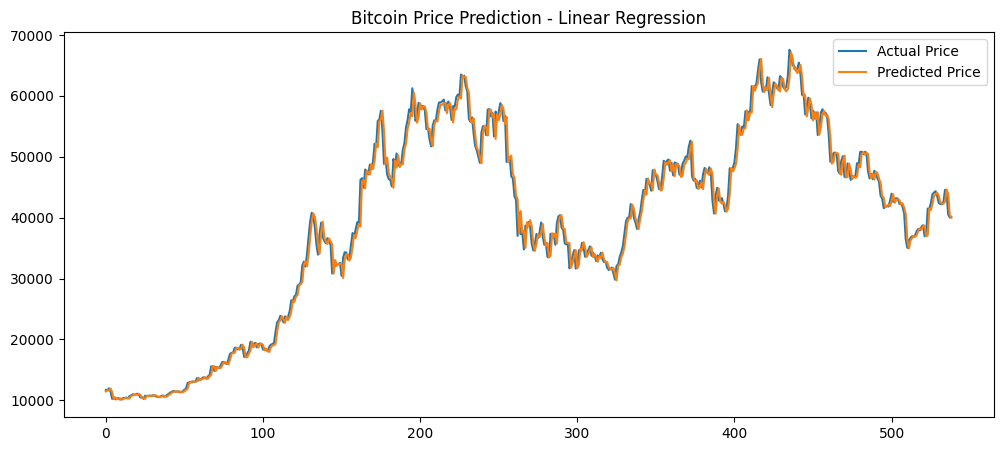

In [23]:
if best_model["model"] == "Linear Regression":
    best_pred = pred_lr
elif best_model["model"] == "Random Forest":
    best_pred = pred_rf
elif best_model["model"] == "SVM (SVR)":
    best_pred = pred_svr
elif best_model["model"] == "XGBoost":
    best_pred = pred_xgb
else:
    best_pred = pred_lstm

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual Price")
plt.plot(best_pred, label="Predicted Price")
plt.title(f"Bitcoin Price Prediction - {best_model['model']}")
plt.legend()
plt.show()


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import xgboost as xgb

# Dictionary of models to train
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200),
    "Support Vector Machine": SVR(kernel="rbf"),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror"
    )
}


In [25]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

Training Linear Regression...
Training Random Forest...
Training Support Vector Machine...
Training XGBoost...


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dictionary to store evaluation metrics
evaluation_results = {}

for name, model in models.items():
    try:
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)

        evaluation_results[name] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2 Score": r2
        }

        print(f"\n{name} Evaluation:")
        print(f"MAE: {mae}")
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"R2 Score: {r2}")

    except:
        print(f"Skipping {name} (model failed prediction)")
        continue

# Display best model based on RMSE
best_model_name = min(evaluation_results, key=lambda x: evaluation_results[x]['RMSE'])
best_model = models[best_model_name]

print("\n---------------------------")
print(f" BEST MODEL: {best_model_name}")
print("---------------------------")
evaluation_results[best_model_name]



Linear Regression Evaluation:
MAE: 1141.0438430586291
MSE: 2724242.6487742322
RMSE: 1650.52799090904
R2 Score: 0.9890662553325539

Random Forest Evaluation:
MAE: 23933.436295013908
MSE: 786995110.7472537
RMSE: 28053.433136556632
R2 Score: -2.1586039515645434

Support Vector Machine Evaluation:
MAE: 35690.326974807984
MSE: 1526795336.7882147
RMSE: 39074.228550135376
R2 Score: -5.1277912888563675

XGBoost Evaluation:
MAE: 24442.10241414019
MSE: 816184728.2147131
RMSE: 28568.94692169652
R2 Score: -2.275756446946417

---------------------------
 BEST MODEL: Linear Regression
---------------------------


{'MAE': 1141.0438430586291,
 'MSE': 2724242.6487742322,
 'RMSE': np.float64(1650.52799090904),
 'R2 Score': 0.9890662553325539}

In [27]:
evaluation_results = {}

for name, model in models.items():
    try:
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)

        evaluation_results[name] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2 Score": r2
        }

        print(f"\n{name} Evaluation:")
        print("MAE:", mae)
        print("MSE:", mse)
        print("RMSE:", rmse)
        print("R2 Score:", r2)

    except Exception as e:
        print(f"Skipping {name} — error: {e}")



Linear Regression Evaluation:
MAE: 1141.0438430586291
MSE: 2724242.6487742322
RMSE: 1650.52799090904
R2 Score: 0.9890662553325539

Random Forest Evaluation:
MAE: 23933.436295013908
MSE: 786995110.7472537
RMSE: 28053.433136556632
R2 Score: -2.1586039515645434

Support Vector Machine Evaluation:
MAE: 35690.326974807984
MSE: 1526795336.7882147
RMSE: 39074.228550135376
R2 Score: -5.1277912888563675

XGBoost Evaluation:
MAE: 24442.10241414019
MSE: 816184728.2147131
RMSE: 28568.94692169652
R2 Score: -2.275756446946417


In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200),
    "SVM": SVR(kernel="rbf"),
}


In [29]:
import requests
import pandas as pd

def fetch_live_binance():
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": "BTCUSDT",
        "interval": "1d",
        "limit": 50
    }

    data = requests.get(url, params=params).json()

    df_live = pd.DataFrame(data, columns=[
        "open_time","Open","High","Low","Close","Volume",
        "close_time","qav","num_trades","taker_base","taker_quote","ignore"
    ])

    df_live[["Open","High","Low","Close","Volume"]] = \
        df_live[["Open","High","Low","Close","Volume"]].astype(float)

    return df_live

df_live = fetch_live_binance()
df_live.tail()


,open_time,Open,High,Low,Close,Volume,close_time,qav,num_trades,taker_base,taker_quote,ignore


In [30]:
# Technical Indicators
df_live["SMA_7"] = df_live["Close"].rolling(7).mean()
df_live["SMA_21"] = df_live["Close"].rolling(21).mean()

df_live["EMA_12"] = df_live["Close"].ewm(span=12, adjust=False).mean()
df_live["EMA_26"] = df_live["Close"].ewm(span=26, adjust=False).mean()

# Bollinger Bands
df_live["BB_Middle"] = df_live["Close"].rolling(20).mean()
df_live["BB_Std"] = df_live["Close"].rolling(20).std()
df_live["BB_Upper"] = df_live["BB_Middle"] + (2 * df_live["BB_Std"])
df_live["BB_Lower"] = df_live["BB_Middle"] - (2 * df_live["BB_Std"])

# RSI
delta = df_live["Close"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df_live["RSI"] = 100 - (100 / (1 + rs))

df_live = df_live.dropna()


In [31]:
print("\n########## CONCLUSION ##########")
print("• The model predicts next-day Bitcoin closing price using ML indicators.")
print("• Useful for short-term trend forecasting.")
print("• Best model:", best_model_name)
print("• Future improvements: LSTM, GRU, Transformers, sentiment analysis, on-chain data, etc.")



########## CONCLUSION ##########
• The model predicts next-day Bitcoin closing price using ML indicators.
• Useful for short-term trend forecasting.
• Best model: Linear Regression
• Future improvements: LSTM, GRU, Transformers, sentiment analysis, on-chain data, etc.
